In [1]:
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
from echo_lv.data import LV_CAMUS_Dataset, LV_EKB_Dataset
from echo_lv.metrics import dice as dice_np
import torch
import torchvision
from torch.utils.data import DataLoader
from torch import sigmoid
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from torchsummary import summary
from echo_lv.utils import AverageMeter
import segmentation_models_pytorch as smp
from echo_lv.segmentation.cnn import mUNet, UNet

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')
print(device)

random_state = 17
np.random.seed(random_state)
torch.manual_seed(random_state)
torch.cuda.manual_seed(random_state)
torch.backends.cudnn.deterministic = True

cuda:0


In [2]:
from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', unicode=True)
rc('text.latex', preamble=r'\usepackage[russian]{babel}')

/home/vasily/.virtualenvs/cnn_course/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  This is separate from the ipykernel package so we can avoid doing imports until


Dataset is correct.


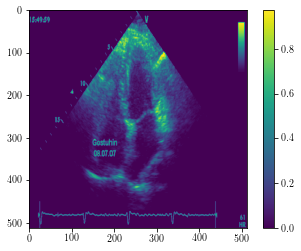

In [3]:
lv_ekb = LV_EKB_Dataset(img_size = (512,512), normalize=True, folds=None)
plt.imshow(np.squeeze(lv_ekb[10][0]))
plt.colorbar()

In [13]:
path_com_result = 'cnn/com_unet2/'
path_mod_result = 'cnn/mod_unet2/'

com_folds = [os.path.join(path_com_result, path) for path in os.listdir(path_com_result) if path.endswith('csv') and path != 'result.csv']
mod_folds = [os.path.join(path_mod_result, path) for path in os.listdir(path_mod_result) if path.endswith('csv') and path != 'result.csv']

df_mod = pd.DataFrame()
for path in mod_folds:
    df = pd.read_csv(path)
    df_mod = pd.concat((df_mod, df), axis=1)
    
df_com = pd.DataFrame()
for path in com_folds:
    df = pd.read_csv(path)
    df_com = pd.concat((df_com, df), axis=1)

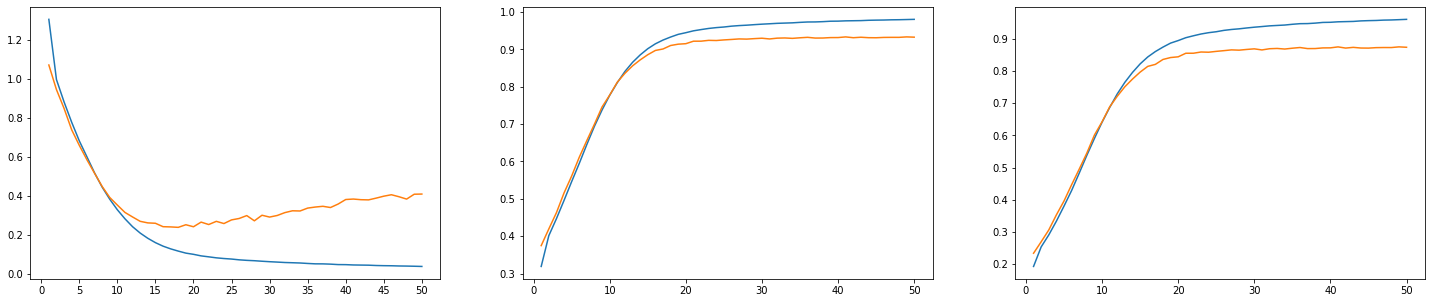

In [14]:
plt.figure(figsize=(25,5))
epochs = np.arange(1, len(df_mod['loss'])+1)
plt.subplot(131)
plt.plot(epochs, df_mod['loss'].mean(axis=1))
plt.plot(epochs, df_mod['val_loss'].mean(axis=1))
plt.xticks(np.arange(0,51,5))

plt.subplot(132)
plt.plot(epochs, df_mod['dice'].mean(axis=1))
plt.plot(epochs, df_mod['val_dice'].mean(axis=1))

plt.subplot(133)
plt.plot(epochs, df_mod['jaccard'].mean(axis=1))
plt.plot(epochs, df_mod['val_jaccard'].mean(axis=1))

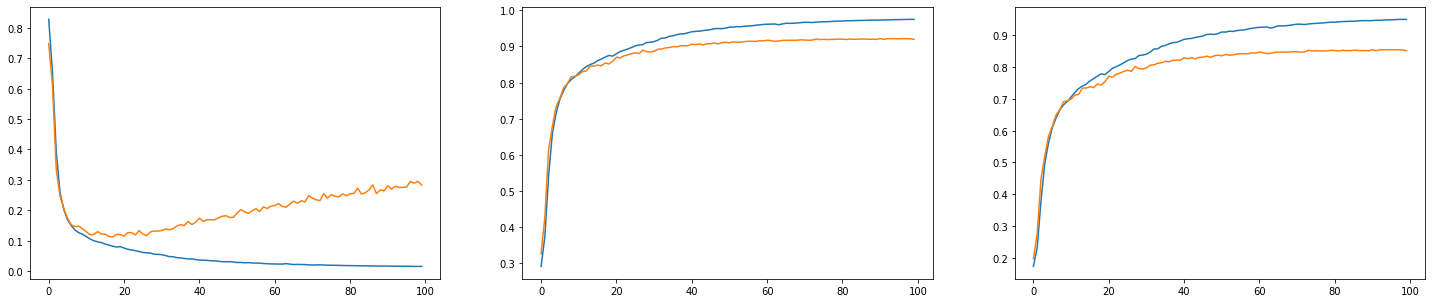

In [15]:
plt.figure(figsize=(25,5))
epochs = np.arange(0, len(df_com['loss']))
plt.subplot(131)
plt.plot(epochs, df_com['loss'].mean(axis=1))
plt.plot(epochs, df_com['val_loss'].mean(axis=1))

plt.subplot(132)
plt.plot(epochs, df_com['dice'].mean(axis=1))
plt.plot(epochs, df_com['val_dice'].mean(axis=1))

plt.subplot(133)
plt.plot(epochs, df_com['jaccard'].mean(axis=1))
plt.plot(epochs, df_com['val_jaccard'].mean(axis=1))

## Кросс-проверка оригинальной Unet

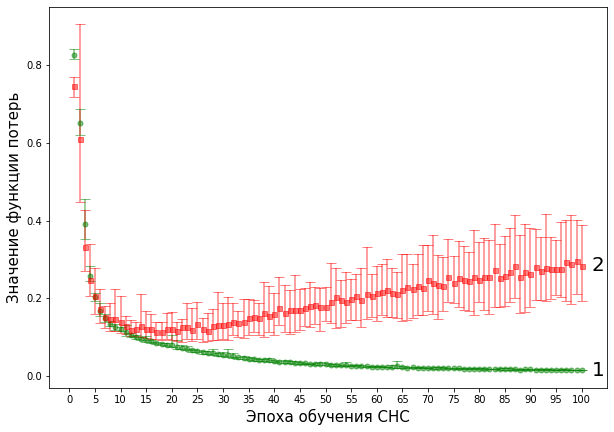

In [16]:
plt.figure(figsize=(10,7))
ts_factor = 0.6

plt.errorbar(np.arange(1, df_com.shape[0]+1), 
             df_com['loss'].mean(axis=1), 
             yerr=np.concatenate((np.expand_dims(df_com['loss'].mean(axis=1) - df_com['loss'].min(axis=1), axis=0), 
                                  np.expand_dims(df_com['loss'].max(axis=1) - df_com['loss'].mean(axis=1), axis=0)), axis=0),
             ms=5,
             color='g',
             alpha=0.5,
             ecolor='g',
             capsize=5,
             marker='o',
             ls=''
            )

plt.errorbar(np.arange(1, df_com.shape[0]+1), 
             df_com['val_loss'].mean(axis=1), 
             yerr=np.concatenate((np.expand_dims(df_com['val_loss'].mean(axis=1) - df_com['val_loss'].min(axis=1), axis=0), 
                                  np.expand_dims(df_com['val_loss'].max(axis=1) - df_com['val_loss'].mean(axis=1), axis=0)), axis=0),
             ms=5,
             color='r',
             alpha=0.5,
             ecolor='r',
             capsize=5,
             marker='s',
             ls=''
            )

# plt.plot(np.arange(1, df_com.shape[0]+1), df_com['val_loss'].mean(axis=1).ewm(alpha=(1 - ts_factor)).mean())

plt.xticks(np.arange(0, df_com.shape[0]+1, 5));
plt.ylabel('Значение функции потерь', fontsize=15)
plt.xlabel('Эпоха обучения СНС', fontsize=15)
plt.text(102, 0.00, '1', fontsize=20)
plt.text(102, 0.27, '2', fontsize=20)
plt.savefig('cnn/results/train_loss_com_unet.png', bbox_inches='tight', pad_inches=0)

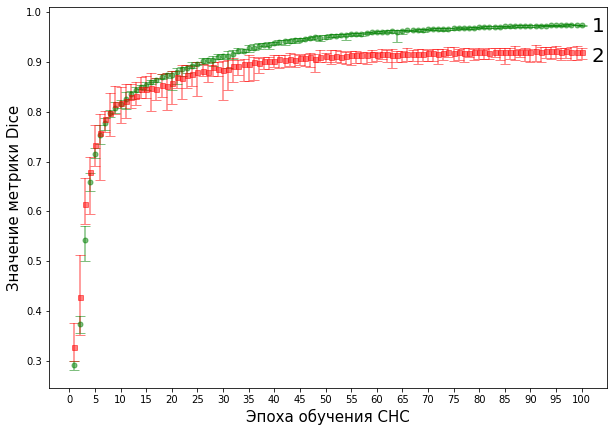

In [17]:
plt.figure(figsize=(10,7))

plt.errorbar(np.arange(1, df_com.shape[0]+1), 
             df_com['dice'].mean(axis=1), 
             yerr=np.concatenate((np.expand_dims(df_com['dice'].mean(axis=1) - df_com['dice'].min(axis=1), axis=0), 
                                  np.expand_dims(df_com['dice'].max(axis=1) - df_com['dice'].mean(axis=1), axis=0)), axis=0),
             ms=5,
             color='g',
             alpha=0.5,
             ecolor='g',
             capsize=5,
             marker='o',
             ls=''
            )

plt.errorbar(np.arange(1, df_com.shape[0]+1), 
             df_com['val_dice'].mean(axis=1), 
             yerr=np.concatenate((np.expand_dims(df_com['val_dice'].mean(axis=1) - df_com['val_dice'].min(axis=1), axis=0), 
                                  np.expand_dims(df_com['val_dice'].max(axis=1) - df_com['val_dice'].mean(axis=1), axis=0)), axis=0),
             ms=5,
             color='r',
             alpha=0.5,
             ecolor='r',
             capsize=5,
             marker='s',
             ls=''
            )

plt.xticks(np.arange(0, df_com.shape[0]+1, 5));
plt.ylabel('Значение метрики Dice', fontsize=15)
plt.xlabel('Эпоха обучения СНС', fontsize=15)
plt.text(102, 0.96, '1', fontsize=20)
plt.text(102, 0.90, '2', fontsize=20)
plt.savefig('cnn/results/train_dice_com_unet.png', bbox_inches='tight', pad_inches=0)

## Кросс-проверка модифицированной UNet

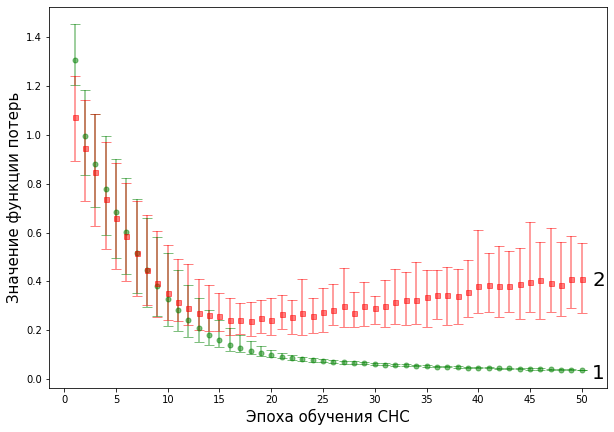

In [18]:
plt.figure(figsize=(10,7))

plt.errorbar(np.arange(1, df_mod.shape[0]+1), 
             df_mod['loss'].mean(axis=1), 
             yerr=np.concatenate((np.expand_dims(df_mod['loss'].mean(axis=1) - df_mod['loss'].min(axis=1), axis=0), 
                                  np.expand_dims(df_mod['loss'].max(axis=1) - df_mod['loss'].mean(axis=1), axis=0)), axis=0),
             ms=5,
             color='g',
             alpha=0.5,
             ecolor='g',
             capsize=5,
             marker='o',
             ls=''
            )

plt.errorbar(np.arange(1, df_mod.shape[0]+1), 
             df_mod['val_loss'].mean(axis=1), 
             yerr=np.concatenate((np.expand_dims(df_mod['val_loss'].mean(axis=1) - df_mod['val_loss'].min(axis=1), axis=0), 
                                  np.expand_dims(df_mod['val_loss'].max(axis=1) - df_mod['val_loss'].mean(axis=1), axis=0)), axis=0),
             ms=5,
             color='r',
             alpha=0.5,
             ecolor='r',
             capsize=5,
             marker='s',
             ls=''
            )

plt.xticks(np.arange(0, df_mod.shape[0]+1, 5));
plt.ylabel('Значение функции потерь', fontsize=15)
plt.xlabel('Эпоха обучения СНС', fontsize=15)
plt.text(51, 0.00, '1', fontsize=20)
plt.text(51, 0.38, '2', fontsize=20)
plt.savefig('cnn/results/train_loss_mod_unet.png', bbox_inches='tight', pad_inches=0)

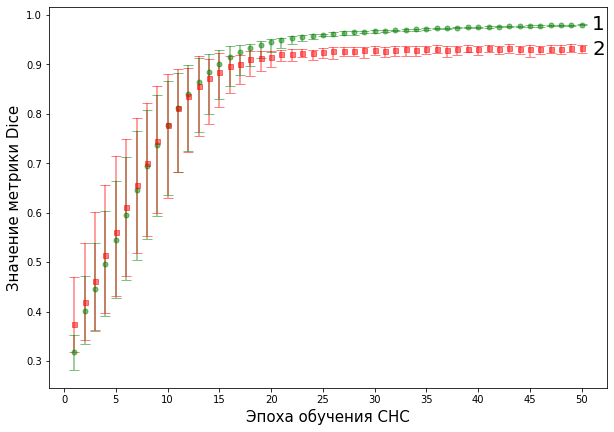

In [19]:
plt.figure(figsize=(10,7))

plt.errorbar(np.arange(1, 1+df_mod.shape[0]), 
             df_mod['dice'].mean(axis=1), 
             yerr=np.concatenate((np.expand_dims(df_mod['dice'].mean(axis=1) - df_mod['dice'].min(axis=1), axis=0), 
                                  np.expand_dims(df_mod['dice'].max(axis=1) - df_mod['dice'].mean(axis=1), axis=0)), axis=0),
             ms=5,
             color='g',
             alpha=0.5,
             ecolor='g',
             capsize=5,
             marker='o',
             ls=''
            )

plt.errorbar(np.arange(1, 1+df_mod.shape[0]), 
             df_mod['val_dice'].mean(axis=1), 
             yerr=np.concatenate((np.expand_dims(df_mod['val_dice'].mean(axis=1) - df_mod['val_dice'].min(axis=1), axis=0), 
                                  np.expand_dims(df_mod['val_dice'].max(axis=1) - df_mod['val_dice'].mean(axis=1), axis=0)), axis=0),
             ms=5,
             color='r',
             alpha=0.5,
             ecolor='r',
             capsize=5,
             marker='s',
             ls=''
            )

plt.xticks(np.arange(0, df_mod.shape[0]+1, 5));
plt.ylabel('Значение метрики Dice', fontsize=15)
plt.xlabel('Эпоха обучения СНС', fontsize=15)
plt.text(51, 0.97, '1', fontsize=20)
plt.text(51, 0.92, '2', fontsize=20)
plt.savefig('cnn/results/train_dice_mod_unet.png', bbox_inches='tight', pad_inches=0)

In [10]:
mod_epoch = 25
com_epoch = 59

print('----Com----')
print('Диапазон вариации на '+ str(com_epoch+1) +' эпохе', (df_com['val_dice'].max(axis=1) - df_com['val_dice'].min(axis=1))[com_epoch])
print('Значение Dice на '+ str(com_epoch+1) +' эпохе', df_com['val_dice'].mean(axis=1)[com_epoch])
print('Относительное значение вариации на '+ str(com_epoch+1) +' эпохе', 100 * (df_com['val_dice'].max(axis=1) - df_com['val_dice'].min(axis=1))[com_epoch] \
      / df_com['val_dice'].mean(axis=1)[99])
print('Значение Dice на последней эпохе: ', df_com['val_dice'].mean(axis=1)[99])
print('Относительное переобучение по Dice на '+ str(com_epoch+1) +' эпохе: ', 100*2 * (df_com['dice'].mean(axis=1) - df_com['val_dice'].mean(axis=1))[com_epoch] \
     / (df_com['dice'].mean(axis=1) + df_com['val_dice'].mean(axis=1))[com_epoch])
print('Относительное переобучение по Loss на '+ str(com_epoch+1) +' эпохе: ', 100*2 * (-df_com['loss'].mean(axis=1) + df_com['val_loss'].mean(axis=1))[com_epoch] \
     / (df_com['loss'].mean(axis=1) + df_com['val_loss'].mean(axis=1))[com_epoch])

print('----Mod----')
print('Диапазон вариации на '+ str(mod_epoch+1) +' эпохе: ', (df_mod['val_dice'].max(axis=1) - df_mod['val_dice'].min(axis=1))[mod_epoch])
print('Значение Dice на '+ str(mod_epoch+1) +' эпохе: ', df_mod['val_dice'].mean(axis=1)[mod_epoch])
print('Относительное значение вариации на '+ str(mod_epoch+1) +' эпохе', 100 *(df_mod['val_dice'].max(axis=1) - df_mod['val_dice'].min(axis=1))[mod_epoch] \
      / df_mod['val_dice'].mean(axis=1)[49])
print('Значение Dice на последней эпохе: ', df_mod['val_dice'].mean(axis=1)[49])
print('Относительное переобучение по Dice на '+ str(mod_epoch+1) +' эпохе: ', 100*2 * (df_mod['dice'].mean(axis=1) - df_mod['val_dice'].mean(axis=1))[mod_epoch] \
      / (df_mod['dice'].mean(axis=1) + df_mod['val_dice'].mean(axis=1))[mod_epoch])
print('Относительное переобучение по Loss на '+ str(mod_epoch+1) +' эпохе: ', 100*2 * (- df_mod['loss'].mean(axis=1) + df_mod['val_loss'].mean(axis=1))[mod_epoch] \
     / (df_mod['loss'].mean(axis=1) + df_mod['val_loss'].mean(axis=1))[mod_epoch])

print(df_mod['val_dice'].mean(axis=1)[49] / df_com['val_dice'].mean(axis=1)[99] - 1)

----Com----
Диапазон вариации на 60 эпохе 0.01830632090568518
Значение Dice на 60 эпохе 0.9151676230960422
Относительное значение вариации на 60 эпохе 1.9913521067098767
Значение Dice на последней эпохе:  0.9192910105652279
Относительное переобучение по Dice на 60 эпохе:  4.850610111282869
Относительное переобучение по Loss на 60 эпохе:  160.94037285889863
----Mod----
Диапазон вариации на 26 эпохе:  0.024314116239547823
Значение Dice на 26 эпохе:  0.926535535785887
Относительное значение вариации на 26 эпохе 2.6069876347767327
Значение Dice на последней эпохе:  0.9326517669359843
Относительное переобучение по Dice на 26 эпохе:  3.7689667566384784
Относительное переобучение по Loss на 26 эпохе:  119.60965340316446
0.014533761580613591


## Cross-validation

In [ ]:
df = pd.read_csv('cnn/mod_unet/result_munet_0.csv')
epochs = np.arange(0, len(df))
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(epochs, df['loss'])
plt.plot(epochs, df['val_loss'])
plt.subplot(122)
plt.plot(epochs, df['dice'])
plt.plot(epochs, df['val_dice'])

In [ ]:
df = pd.read_csv('cnn/com_unet/result_cunet_0.csv')
epochs = np.arange(0, len(df))
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(epochs, df['loss'])
plt.plot(epochs, df['val_loss'])
plt.subplot(122)
plt.plot(epochs, df['dice'])
plt.plot(epochs, df['val_dice'])

[ 7.21709043e+00  1.32494319e-01  1.84657017e-02  3.31064245e-01
 -2.91271937e+00 -5.35854634e+01]


(0.7, 1.0)

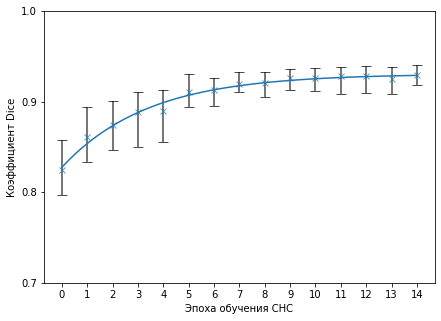

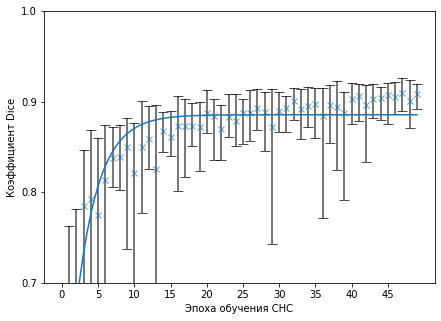

In [45]:
import os
import pandas as pd
from scipy.optimize import curve_fit

def func(t, a, b, c, d, e, f):
    return a / (b + c * np.exp(-d*t + e)) + f
    
plt.errorbar(np.arange(df_mod_vl.shape[0]), 
             df_mod['val_dice'].mean(axis=1), 
             yerr=np.concatenate((np.expand_dims(df_mod['val_dice'].mean(axis=1) - df_mod['val_dice'].min(axis=1), axis=0), 
                                  np.expand_dims(df_mod['val_dice'].max(axis=1) - df_mod['val_dice'].mean(axis=1), axis=0)), axis=0),
             alpha=0.7,
             ecolor='black',
             capsize=5,
             marker='x',
             ls=''
            )

# plt.scatter(np.arange(0, 15), df_mod_ls.mean(axis=1), marker='x')
# plt.scatter(np.arange(0, 15), df_mod_tr.mean(axis=1) - df_mod_vl.mean(axis=1), marker='x')

popt, pcov = curve_fit(func, np.arange(len(df_mod['val_dice'].mean(axis=1))), df_mod['val_dice'].mean(axis=1), (1, 1, 0.9, 0.45, -2.2, -0.065), maxfev=10**6)
plt.plot(np.linspace(0,14,100), func(np.linspace(0,14,100), *popt))

# print(popt)
# plt.scatter(np.arange(df_mod.shape[0]), df_mod.mean(axis=1), marker='x')
plt.ylabel('Коэффициент Dice')
plt.xlabel('Эпоха обучения СНС')
plt.xticks(ticks=np.arange(15))
plt.yticks(ticks=np.linspace(0, 1, 11))
# plt.grid()
plt.ylim([0.7, 1])
# plt.savefig('cnn/results/train_mod_unet.png', bbox_inches='tight', pad_inches=0)


plt.figure(figsize=(7,5))
# plt.subplot(122)

    
plt.errorbar(np.arange(df_com.shape[0]), 
             df_com.mean(axis=1), 
             yerr=np.concatenate((np.expand_dims(df_com.mean(axis=1) - df_com.min(axis=1), axis=0), 
                                  np.expand_dims(df_com.max(axis=1) - df_com.mean(axis=1), axis=0)), axis=0),
             alpha=0.7,
             ecolor='black',
             capsize=5,
             marker='x',
             ls=''
            )
popt, pcov = curve_fit(func, np.arange(len(df_com.mean(axis=1)[0:50])), df_com.mean(axis=1)[0:50], (1, 1, 1, 0.15, -1, -0.1), maxfev=10**6)
print(popt)
plt.plot(np.linspace(0,49,100), func(np.linspace(0,49,100), *popt))

# plt.grid()
plt.ylabel('Коэффициент Dice')
plt.xlabel('Эпоха обучения СНС')
plt.xticks(ticks=np.arange(0,50, 5))
plt.yticks(ticks=np.linspace(0, 1, 11))
plt.ylim([0.7, 1])
# plt.savefig('cnn/results/train_com_unet.png', bbox_inches='tight', pad_inches=0)

# Test on USEKB

In [7]:
common_unet = UNet(1, 1, False)
common_unet.load_state_dict(torch.load('common_unet.pth'))
common_unet.to(device)
common_unet.eval();
modified_unet = mUNet(1, 1, dropout=0.0)
modified_unet.load_state_dict(torch.load('modified_unet.pth'))
modified_unet.to(device)
modified_unet.eval();

In [4]:
# summary(common_unet, (1, 572, 572), device='cpu')

In [5]:
# summary(modified_unet, (1, 512, 512), device='cuda')

In [6]:
criterion = smp.utils.losses.DiceLoss(activation='sigmoid').to(device) # + smp.utils.losses.BCEWithLogitsLoss(pos_weight=weight) 
dice = smp.utils.metrics.Fscore(activation='sigmoid', threshold=0.5).to(device)#Dice()
iou = smp.utils.metrics.IoU(activation='sigmoid', threshold=0.5).to(device)

In [7]:
lv_ekb = LV_EKB_Dataset(img_size=(388,388), shuffle=False, normalize=True)
test_loader = DataLoader(lv_ekb, batch_size=1, shuffle=False, num_workers=2)

average_total_loss = AverageMeter()
average_dice = AverageMeter()
average_jaccard = AverageMeter()

t = tqdm(total=len(test_loader), 
        bar_format='{desc} | {postfix[0]}/'+ str(len(test_loader)) +' | ' +
        '{postfix[1]} : {postfix[2]:>2.4f} | {postfix[3]} : {postfix[4]:>2.4f} | {postfix[5]} : {postfix[6]:>2.4f} |',
        postfix=[0, 'loss', 0, 'dice_lv', 0,  'jaccard_lv', 0], 
        desc = 'Test common unet on USEKB',
        position=0, leave=True
     )

results_com_1 = {'loss' : [], 'dice' : [], 'jaccard' : []}
i = 1
for data in test_loader:
    inputs, masks, *_ = data
    shape = inputs.shape
    inputs = torch.cat([torch.zeros((shape[0], shape[1], shape[2], 92), dtype=float), inputs, torch.zeros((shape[0], shape[1], shape[2], 92), dtype=float)], axis=3)
    shape = inputs.shape
    inputs = torch.cat([torch.zeros((shape[0], shape[1], 92, shape[3]), dtype=float), inputs, torch.zeros((shape[0], shape[1], 92, shape[3]), dtype=float)], axis=2)
    inputs=inputs.to(device).float()
    masks=masks.to(device).float()

    outputs = common_unet(inputs)

    loss = criterion(outputs, masks)

    l = loss.data.item()
    d = dice(outputs, masks).item()
    j = iou(outputs, masks).item()
    average_total_loss.update(l)
    average_dice.update(d)
    average_jaccard.update(j)
    
    t.postfix[0] = i
    t.postfix[2] = average_total_loss.average()
    t.postfix[4] = average_dice.average()
    t.postfix[6] = average_jaccard.average()
    results_com_1['loss'].append(l)
    results_com_1['dice'].append(d)
    results_com_1['jaccard'].append(j)
    t.update(n=1)
    i += 1
t.close()

Dataset is correct.


Test common unet on USEKB | 2771/2771 | loss : 0.1870 | dice_lv : 0.8226 | jaccard_lv : 0.7058 |


In [8]:
lv_ekb = LV_EKB_Dataset(img_size=(512,512), shuffle=False, normalize=True, patient_cat={'DKMP', 'Norma', 'Norma_Old', 'Pathology_Old'},) #Norma_Old', 'Pathology_Old'
test_loader = DataLoader(lv_ekb, batch_size=1, shuffle=False, num_workers=2)

average_total_loss = AverageMeter()
average_dice = AverageMeter()
average_jaccard = AverageMeter()

t = tqdm(total=len(test_loader), 
        bar_format='{desc} | {postfix[0]}/'+ str(len(test_loader)) +' | ' +
        '{postfix[1]} : {postfix[2]:>2.4f} | {postfix[3]} : {postfix[4]:>2.4f} | {postfix[5]} : {postfix[6]:>2.4f} |',
        postfix=[0, 'loss', 0, 'dice_lv', 0,  'jaccard_lv', 0], 
        desc = 'Test modified unet on USEKB',
        position=0, leave=True
     )

results_mod_1 = {'loss' : [], 'dice' : [], 'jaccard' : []}
i = 1
for data in test_loader:
    inputs, masks, *_ = data

    inputs=inputs.to(device).float()
    masks=masks.to(device).float()

    outputs = modified_unet(inputs)

    loss = criterion(outputs, masks)

    l = loss.data.item()
    d = dice(outputs, masks).item()
    j = iou(outputs, masks).item()
    average_total_loss.update(l)
    average_dice.update(d)
    average_jaccard.update(j)
    
    t.postfix[0] = i
    t.postfix[2] = average_total_loss.average()
    t.postfix[4] = average_dice.average()
    t.postfix[6] = average_jaccard.average()
    results_mod_1['loss'].append(l)
    results_mod_1['dice'].append(d)
    results_mod_1['jaccard'].append(j)
    t.update(n=1)
    i += 1
t.close()

Dataset is correct.


Test modified unet on USEKB | 2771/2771 | loss : 0.1710 | dice_lv : 0.8341 | jaccard_lv : 0.7227 |


In [71]:
common_unet = UNet(1, 1, False)
common_unet.load_state_dict(torch.load('common_unet_1st_frame.pth'))
common_unet.to(device)
common_unet.eval();
modified_unet = mUNet(1, 1, dropout=0.0)
modified_unet.load_state_dict(torch.load('modified_unet_1st_frame.pth'))
modified_unet.to(device)
modified_unet.eval();

In [ ]:
lv_ekb = LV_EKB_Dataset(img_size=(388,388), shuffle=False, normalize=True)
test_loader = DataLoader(lv_ekb, batch_size=1, shuffle=False, num_workers=2)

average_total_loss = AverageMeter()
average_dice = AverageMeter()
average_jaccard = AverageMeter()

t = tqdm(total=len(test_loader), 
        bar_format='{desc} | {postfix[0]}/'+ str(len(test_loader)) +' | ' +
        '{postfix[1]} : {postfix[2]:>2.4f} | {postfix[3]} : {postfix[4]:>2.4f} | {postfix[5]} : {postfix[6]:>2.4f} |',
        postfix=[0, 'loss', 0, 'dice_lv', 0,  'jaccard_lv', 0], 
        desc = 'Test common unet on USEKB',
        position=0, leave=True
     )

results_com_2 = {'loss' : [], 'dice' : [], 'jaccard' : []}
i = 1
for data in test_loader:
    inputs, masks, *_ = data
    shape = inputs.shape
    inputs = torch.cat([torch.zeros((shape[0], shape[1], shape[2], 92), dtype=float), inputs, torch.zeros((shape[0], shape[1], shape[2], 92), dtype=float)], axis=3)
    shape = inputs.shape
    inputs = torch.cat([torch.zeros((shape[0], shape[1], 92, shape[3]), dtype=float), inputs, torch.zeros((shape[0], shape[1], 92, shape[3]), dtype=float)], axis=2)
    inputs=inputs.to(device).float()
    masks=masks.to(device).float()

    outputs = common_unet(inputs)

    loss = criterion(outputs, masks)

    l = loss.data.item()
    d = dice(outputs, masks).item()
    j = iou(outputs, masks).item()
    average_total_loss.update(l)
    average_dice.update(d)
    average_jaccard.update(j)
    
    t.postfix[0] = i
    t.postfix[2] = average_total_loss.average()
    t.postfix[4] = average_dice.average()
    t.postfix[6] = average_jaccard.average()
    results_com_2['loss'].append(l)
    results_com_2['dice'].append(d)
    results_com_2['jaccard'].append(j)
    t.update(n=1)
    i += 1
t.close()

Dataset is correct.


Test common unet on USEKB | 2771/2771 | loss : 0.2091 | dice_lv : 0.8468 | jaccard_lv : 0.7418 |


In [ ]:
lv_ekb = LV_EKB_Dataset(img_size=(512,512), shuffle=False, normalize=True, patient_cat={'DKMP', 'Norma', 'Norma_Old', 'Pathology_Old'},) #Norma_Old', 'Pathology_Old'
test_loader = DataLoader(lv_ekb, batch_size=1, shuffle=False, num_workers=2)

average_total_loss = AverageMeter()
average_dice = AverageMeter()
average_jaccard = AverageMeter()

t = tqdm(total=len(test_loader), 
        bar_format='{desc} | {postfix[0]}/'+ str(len(test_loader)) +' | ' +
        '{postfix[1]} : {postfix[2]:>2.4f} | {postfix[3]} : {postfix[4]:>2.4f} | {postfix[5]} : {postfix[6]:>2.4f} |',
        postfix=[0, 'loss', 0, 'dice_lv', 0,  'jaccard_lv', 0], 
        desc = 'Test modified unet on USEKB',
        position=0, leave=True
     )

results_mod_2 = {'loss' : [], 'dice' : [], 'jaccard' : []}
i = 1
for data in test_loader:
    inputs, masks, *_ = data

    inputs=inputs.to(device).float()
    masks=masks.to(device).float()

    outputs = modified_unet(inputs)

    loss = criterion(outputs, masks)

    l = loss.data.item()
    d = dice(outputs, masks).item()
    j = iou(outputs, masks).item()
    average_total_loss.update(l)
    average_dice.update(d)
    average_jaccard.update(j)
    
    t.postfix[0] = i
    t.postfix[2] = average_total_loss.average()
    t.postfix[4] = average_dice.average()
    t.postfix[6] = average_jaccard.average()
    results_mod_2['loss'].append(l)
    results_mod_2['dice'].append(d)
    results_mod_2['jaccard'].append(j)
    t.update(n=1)
    i += 1
t.close()

Dataset is correct.


Test modified unet on USEKB | 2771/2771 | loss : 0.1128 | dice_lv : 0.8944 | jaccard_lv : 0.8133 |


In [20]:
print(np.median(results_com_1['dice']))
print(np.median(results_mod_1['dice']))
print(np.median(results_com_2['dice']))
print(np.median(results_mod_2['dice']))

0.8359240293502808
0.8501785397529602
0.8641706109046936
0.9051728248596191


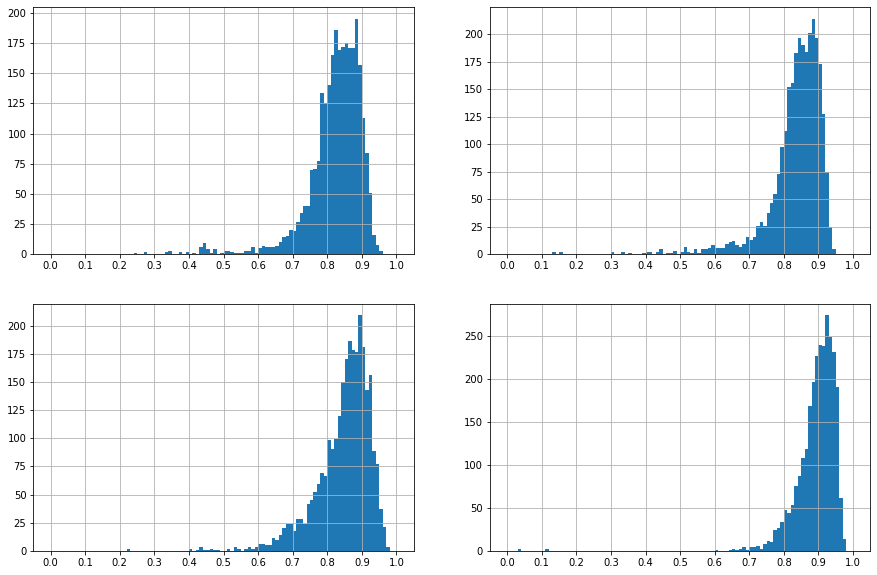

In [18]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.hist(results_com_1['dice'], bins=100, range=[0,1]);
plt.xticks(ticks=np.linspace(0, 1, 11))
plt.grid()
plt.subplot(222)
plt.hist(results_mod_1['dice'], bins=100, range=[0,1]);
plt.xticks(ticks=np.linspace(0, 1, 11))
plt.grid()
plt.subplot(223)
plt.hist(results_com_2['dice'], bins=100, range=[0,1]);
plt.xticks(ticks=np.linspace(0, 1, 11))
plt.grid()
plt.subplot(224)
plt.hist(results_mod_2['dice'], bins=100, range=[0,1]);
plt.xticks(ticks=np.linspace(0, 1, 11))
plt.grid()

In [19]:
import pandas as pd
df = pd.DataFrame(results_mod_1)
df.to_csv('cnn/results/mod_unet_camus.csv', header=True, index=False,)
df = pd.DataFrame(results_com_1)
df.to_csv('cnn/results/com_unet_camus.csv', header=True, index=False,)
df = pd.DataFrame(results_mod_2)
df.to_csv('cnn/results/mod_unet_camus+usekb.csv', header=True, index=False,)
df = pd.DataFrame(results_com_2)
df.to_csv('cnn/results/com_unet_camus+usekb.csv', header=True, index=False,)

## Обычная Unet

In [8]:
folds = 10
lv_camus = LV_CAMUS_Dataset(img_size = (388,388), classes = {0, 1}, folds=folds)
lv_camus.set_state('valid', 0)

In [9]:
img, msk, *_ = lv_camus[5]
imgs = torch.tensor(np.expand_dims(img, axis=0))
msks = torch.tensor(np.expand_dims(msk, axis=0))
shape = imgs.shape
imgs = torch.cat([torch.zeros((shape[0], shape[1], shape[2], 92), dtype=float), imgs, torch.zeros((shape[0], shape[1], shape[2], 92), dtype=float)], axis=3)
shape = imgs.shape
imgs = torch.cat([torch.zeros((shape[0], shape[1], 92, shape[3]), dtype=float), imgs, torch.zeros((shape[0], shape[1], 92, shape[3]), dtype=float)], axis=2)

(-92.0, 480.0, 480.0, -92.0)

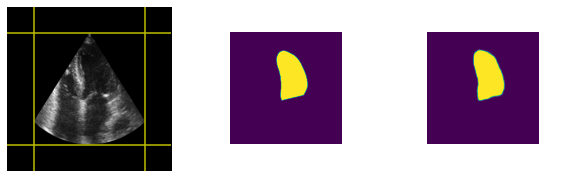

In [10]:
outputs = common_unet(imgs.to(device).float())
plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(imgs[0,0,:,:], cmap = plt.cm.gray)
plt.vlines(92, 0, 571, colors='y',)
plt.vlines(480, 0, 571, colors='y')
plt.hlines(92, 0, 571, colors='y',)
plt.hlines(480, 0, 571, colors='y')
plt.axis('off')
plt.subplot(132)
m = msks[0,0,:,:].cpu().detach().numpy()
plt.xlim(-92, 480)
plt.ylim(-92, 480)
# plt.vlines(92, 0, 571, colors='y',)
# plt.vlines(480, 0, 571, colors='y')
# plt.hlines(92, 0, 571, colors='y',)
# plt.hlines(480, 0, 571, colors='y')
plt.gca().invert_yaxis()
plt.imshow(m)
plt.axis('off')
# plt.title('Экспертная маска ЛЖ')
plt.subplot(133)
o = sigmoid(outputs).cpu().detach().numpy()[0][0]
plt.xlim(-92, 480)
plt.ylim(-92, 480)
# plt.vlines(-92, -92, 480, colors='y',)
# plt.vlines(480, -92, 480, colors='y')
# plt.hlines(-92, -92, 480, colors='y',)
# plt.hlines(480, -92, 480, colors='y')
plt.gca().invert_yaxis()
plt.imshow(o)
# plt.title('Выходное изображение СНС')
plt.axis('off')

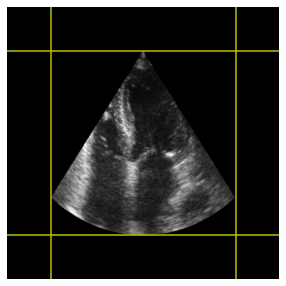

In [11]:
plt.figure(figsize=(5,5))
plt.imshow(imgs[0,0,:,:], cmap = plt.cm.gray)
plt.vlines(92, 0, 571, colors='y',)
plt.vlines(480, 0, 571, colors='y')
plt.hlines(92, 0, 571, colors='y',)
plt.hlines(480, 0, 571, colors='y')
plt.axis('off')
plt.savefig('cnn/us_image_common_unet.png', bbox_inches='tight', pad_inches=0,)

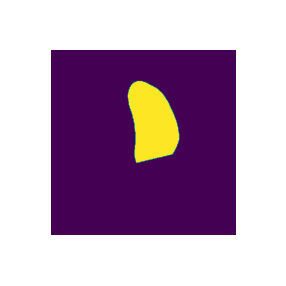

In [12]:
plt.figure(figsize=(5,5))
plt.imshow(m)
plt.xlim(-92, 480)
plt.ylim(-92, 480)
plt.gca().invert_yaxis()
plt.axis('off')
plt.savefig('cnn/mask_common_unet.png', bbox_inches='tight', pad_inches=0,)

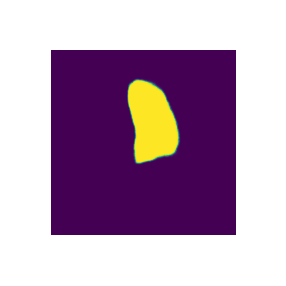

In [13]:
plt.figure(figsize=(5,5))
plt.xlim(-92, 480)
plt.ylim(-92, 480)
plt.gca().invert_yaxis()
plt.imshow(o)
plt.axis('off')
plt.savefig('cnn/result_common_unet.png', bbox_inches='tight', pad_inches=0,)

In [88]:
index = 1
lv_ekb = LV_EKB_Dataset(img_size = (388,388), normalize=True)

Dataset is correct.


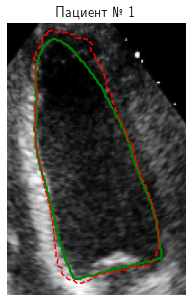

In [89]:
imgs, msks = lv_ekb.get_sequence('04', 'Norma')
img, msk = imgs[index], msks[index]
imgs = torch.tensor(np.expand_dims(imgs[0], axis=[0,1]))
msks = torch.tensor(np.expand_dims(msks[0], axis=[0,1]))
shape = imgs.shape
imgs = torch.cat([torch.zeros((shape[0], shape[1], shape[2], 92), dtype=float), imgs, torch.zeros((shape[0], shape[1], shape[2], 92), dtype=float)], axis=3)
shape = imgs.shape
imgs = torch.cat([torch.zeros((shape[0], shape[1], 92, shape[3]), dtype=float), imgs, torch.zeros((shape[0], shape[1], 92, shape[3]), dtype=float)], axis=2)
outputs = common_unet(imgs.to(device).float())
m = msks[0,0,:,:].cpu().detach().numpy()
o = sigmoid(outputs).cpu().detach().numpy()[0][0]
plt.figure(figsize=(10,5))
plt.imshow(img, cmap = plt.cm.gray)
plt.contour(m, 1, colors='g')
plt.contour(o, 1, colors='r', linestyles='dashed')
plt.axis('off')
plt.title(r'Пациент № 1', fontsize=15)
plt.xlim(np.round(215 * 388 / 512), np.round(365 * 388 / 512))
plt.ylim(np.round(130 * 388 / 512), np.round(360 * 388 / 512))
plt.gca().invert_yaxis()
plt.savefig('cnn/us_image_res_common_unet_1.png', bbox_inches='tight', pad_inches=0)

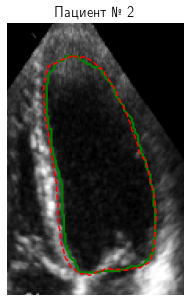

In [90]:
imgs, msks = lv_ekb.get_sequence('21', 'Norma_Old')
img, msk = imgs[index], msks[index]
imgs = torch.tensor(np.expand_dims(imgs[0], axis=[0,1]))
msks = torch.tensor(np.expand_dims(msks[0], axis=[0,1]))
shape = imgs.shape
imgs = torch.cat([torch.zeros((shape[0], shape[1], shape[2], 92), dtype=float), imgs, torch.zeros((shape[0], shape[1], shape[2], 92), dtype=float)], axis=3)
shape = imgs.shape
imgs = torch.cat([torch.zeros((shape[0], shape[1], 92, shape[3]), dtype=float), imgs, torch.zeros((shape[0], shape[1], 92, shape[3]), dtype=float)], axis=2)
outputs = common_unet(imgs.to(device).float())
m = msks[0,0,:,:].cpu().detach().numpy()
o = sigmoid(outputs).cpu().detach().numpy()[0][0]
plt.figure(figsize=(10,5))
plt.imshow(img, cmap = plt.cm.gray)
plt.contour(m, 1, colors='g')
plt.contour(o, 1, colors='r', linestyles='dashed')
plt.axis('off')
plt.title(r'Пациент № 2', fontsize=15)
plt.xlim(np.round(200 * 388 / 512), np.round(350 * 388 / 512))
plt.ylim(np.round(30 * 388 / 512), np.round(260 * 388 / 512))
plt.gca().invert_yaxis()
plt.savefig('cnn/us_image_res_common_unet_2.png', bbox_inches='tight', pad_inches=0)

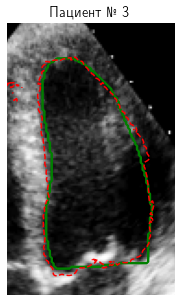

In [91]:
imgs, msks = lv_ekb.get_sequence('05', 'DKMP')
img, msk = imgs[index], msks[index]
imgs = torch.tensor(np.expand_dims(imgs[0], axis=[0,1]))
msks = torch.tensor(np.expand_dims(msks[0], axis=[0,1]))
shape = imgs.shape
imgs = torch.cat([torch.zeros((shape[0], shape[1], shape[2], 92), dtype=float), imgs, torch.zeros((shape[0], shape[1], shape[2], 92), dtype=float)], axis=3)
shape = imgs.shape
imgs = torch.cat([torch.zeros((shape[0], shape[1], 92, shape[3]), dtype=float), imgs, torch.zeros((shape[0], shape[1], 92, shape[3]), dtype=float)], axis=2)
outputs = common_unet(imgs.to(device).float())
m = msks[0,0,:,:].cpu().detach().numpy()
o = sigmoid(outputs).cpu().detach().numpy()[0][0]
plt.figure(figsize=(10,5))
plt.imshow(img, cmap = plt.cm.gray)
plt.contour(m, 1, colors='g')
plt.contour(o, 1, colors='r', linestyles='dashed')
plt.axis('off')
plt.title(r'Пациент № 3', fontsize=15)
plt.xlim(np.round(240 * 388 / 512), np.round(360 * 388 / 512))
plt.ylim(np.round(120 * 388 / 512), np.round(315 * 388 / 512))
# plt.xlim(np.round(200 * 388 / 512), np.round(360 * 388 / 512))
# plt.ylim(np.round(120 * 388 / 512), np.round(415 * 388 / 512))
plt.gca().invert_yaxis()
plt.savefig('cnn/us_image_res_common_unet_3.png', bbox_inches='tight', pad_inches=0)

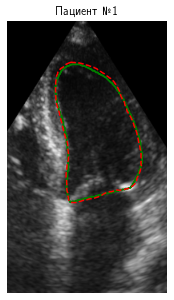

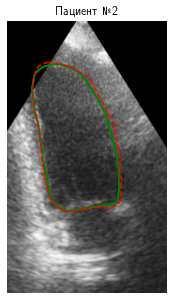

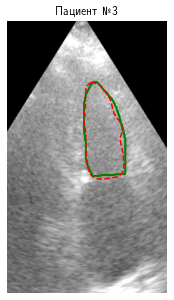

In [14]:
indexes = [5, 30, 50]
xs = [(100,300), (100,300), (100,300)]
ys = [(10,350), (10,350), (10,350),]
for i, (index, xlim, ylim) in enumerate(zip(indexes, xs, ys)):
    img, msk, *_ = lv_camus[index]
    imgs = torch.tensor(np.expand_dims(img, axis=0))
    msks = torch.tensor(np.expand_dims(msk, axis=0))
    shape = imgs.shape
    imgs = torch.cat([torch.zeros((shape[0], shape[1], shape[2], 92), dtype=float), imgs, torch.zeros((shape[0], shape[1], shape[2], 92), dtype=float)], axis=3)
    shape = imgs.shape
    imgs = torch.cat([torch.zeros((shape[0], shape[1], 92, shape[3]), dtype=float), imgs, torch.zeros((shape[0], shape[1], 92, shape[3]), dtype=float)], axis=2)
    outputs = common_unet(imgs.to(device).float())
    m = msks[0,0,:,:].cpu().detach().numpy()
    o = sigmoid(outputs).cpu().detach().numpy()[0][0]
    plt.figure(figsize=(5,5))
    plt.imshow(img[0], cmap = plt.cm.gray)
    plt.contour(m, 1, colors='g')
    plt.contour(o, 1, colors='r', linestyles='dashed')
    plt.axis('off')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.gca().invert_yaxis()
    plt.title('Пациент №' + str(i+1))
    plt.savefig('cnn/us_image_res_common_unet_'+str(i+1) +'.png', bbox_inches='tight', pad_inches=0,)

## Модифицированная архитектура

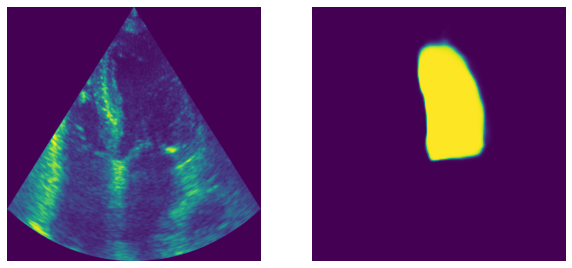

In [15]:
folds = 10
lv_camus = LV_CAMUS_Dataset(img_size = (512,512), classes = {0, 1}, folds=folds)
lv_camus.set_state('valid', 0)
img, msk, *_ = lv_camus[5]
imgs = torch.tensor(np.expand_dims(img, axis=0))
msks = torch.tensor(np.expand_dims(msk, axis=0))

outputs = sigmoid(modified_unet(imgs.to(device).float()))
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(imgs[0,0,:,:])
plt.axis('off')
plt.subplot(122)
o = outputs[0,0,:,:].cpu().detach().numpy()
plt.imshow(o)
plt.axis('off')
# plt.subplot(133)
m = msks[0,0,:,:].cpu().detach().numpy()

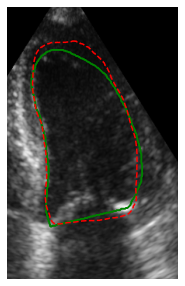

In [44]:
plt.figure(figsize=(5,5))
plt.imshow(imgs[0,0,], cmap = plt.cm.gray)
plt.contour(m, 1, colors='g')
plt.contour(o, 1, colors='r', linestyles='dashed')
plt.axis('off')
plt.xlim(180,400)
plt.ylim(30,380)
plt.gca().invert_yaxis()
plt.savefig('cnn/us_image_res_modified_unet.png', bbox_inches='tight', pad_inches=0,)

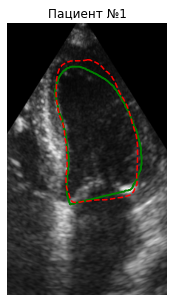

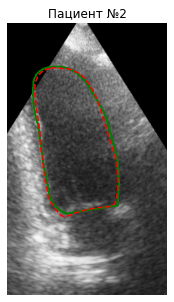

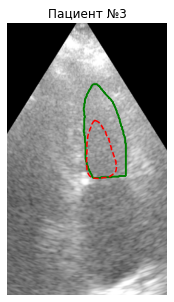

In [19]:
indexes = [5, 30, 50]
xs = [(100 * 512/388,300 * 512/388), (100 * 512/388,300* 512/388), (100* 512/388,300* 512/388)]
ys = [(10* 512/388,350* 512/388), (10* 512/388,350* 512/388), (10* 512/388,350* 512/388),]
for i, (index, xlim, ylim) in enumerate(zip(indexes, xs, ys)):
    img, msk, *_ = lv_camus[index]
    imgs = torch.tensor(np.expand_dims(img, axis=0))
    msks = torch.tensor(np.expand_dims(msk, axis=0))
    outputs = modified_unet(imgs.to(device).float())
    m = msks[0,0,:,:].cpu().detach().numpy()
    o = sigmoid(outputs).cpu().detach().numpy()[0][0]
    plt.figure(figsize=(5,5))
    plt.imshow(img[0], cmap = plt.cm.gray)
    plt.contour(m, 1, colors='g')
    plt.contour(o, 1, colors='r', linestyles='dashed')
    plt.axis('off')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.gca().invert_yaxis()
    plt.title('Пациент №' + str(i+1))
    plt.savefig('cnn/us_image_res_modified_unet_'+str(i+1) +'.png', bbox_inches='tight', pad_inches=0,)

In [92]:
lv_ekb = LV_EKB_Dataset(img_size = (512,512), normalize=True)

Dataset is correct.


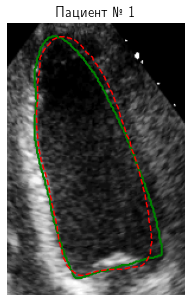

In [93]:
imgs, msks = lv_ekb.get_sequence('04', 'Norma')
img, msk = imgs[index], msks[index]
imgs = torch.tensor(np.expand_dims(img, axis=[0,1]))
msks = torch.tensor(np.expand_dims(msk, axis=[0,1]))
outputs = modified_unet(imgs.to(device).float())
m = msks[0,0,:,:].cpu().detach().numpy()
o = sigmoid(outputs).cpu().detach().numpy()[0][0]
plt.figure(figsize=(5,5))
plt.imshow(img, cmap = plt.cm.gray)
plt.contour(m, 1, colors='g')
plt.contour(o, 1, colors='r', linestyles='dashed')
plt.axis('off')
plt.xlim(215, 365)
plt.ylim(130, 360)
plt.gca().invert_yaxis()
plt.title('Пациент № 1', fontsize=15)
plt.savefig('cnn/us_image_res_modified_unet_1.png', bbox_inches='tight', pad_inches=0,)

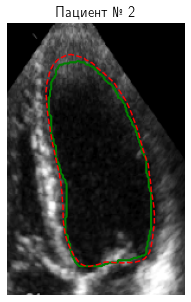

In [94]:
imgs, msks = lv_ekb.get_sequence('21', 'Norma_Old')
img, msk = imgs[index], msks[index]
imgs = torch.tensor(np.expand_dims(img, axis=[0,1]))
msks = torch.tensor(np.expand_dims(msk, axis=[0,1]))
outputs = modified_unet(imgs.to(device).float())
m = msks[0,0,:,:].cpu().detach().numpy()
o = sigmoid(outputs).cpu().detach().numpy()[0][0]
plt.figure(figsize=(5,5))
plt.imshow(img, cmap = plt.cm.gray)
plt.contour(m, 1, colors='g')
plt.contour(o, 1, colors='r', linestyles='dashed')
plt.axis('off')
plt.xlim(200, 350)
plt.ylim(30, 260)
plt.gca().invert_yaxis()
plt.title('Пациент № 2', fontsize=15)
plt.savefig('cnn/us_image_res_modified_unet_2.png', bbox_inches='tight', pad_inches=0,)

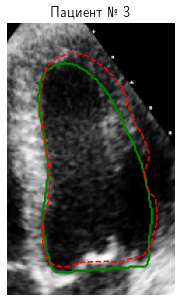

In [95]:
imgs, msks = lv_ekb.get_sequence('05', 'DKMP')
img, msk = imgs[index], msks[index]
imgs = torch.tensor(np.expand_dims(img, axis=[0,1]))
msks = torch.tensor(np.expand_dims(msk, axis=[0,1]))
outputs = modified_unet(imgs.to(device).float())
m = msks[0,0,:,:].cpu().detach().numpy()
o = sigmoid(outputs).cpu().detach().numpy()[0][0]
plt.figure(figsize=(5,5))
plt.imshow(img, cmap = plt.cm.gray)
plt.contour(m, 1, colors='g')
plt.contour(o, 1, colors='r', linestyles='dashed')
plt.axis('off')
plt.xlim(240, 360)
plt.ylim(120, 315)
# plt.xlim(200, 360)
# plt.ylim(120, 415)
plt.gca().invert_yaxis()
plt.title('Пациент № 3', fontsize=15)
plt.savefig('cnn/us_image_res_modified_unet_3.png', bbox_inches='tight', pad_inches=0,)